# Restaurant Visitor Forecasting

## 1. Data Preprocessing

In [1]:
import pandas as pd

air_visit = pd.read_csv('data/air_visit_data.csv')
air_reserve = pd.read_csv('data/air_reserve.csv')
hpg_reserve = pd.read_csv('data/hpg_reserve.csv')
air_store_info = pd.read_csv('data/air_store_info.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')
store_id_relation = pd.read_csv('data/store_id_relation.csv')
date_info = pd.read_csv('data/date_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

Converting to datetime format

In [2]:
for df in [air_reserve, hpg_reserve]:
    df['visit_datetime'] = pd.to_datetime(df['visit_datetime']).dt.date
    df['reserve_datetime'] = pd.to_datetime(df['reserve_datetime']).dt.date

air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date']).dt.date
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date

Aggregating Reservation Data
- Total reservations per day
- Average reservation lead time (gap between reservation and visit)

In [3]:
air_reserve['reserve_lead_time'] = (
    pd.to_datetime(air_reserve['visit_datetime']) - 
    pd.to_datetime(air_reserve['reserve_datetime'])
).dt.days

air_agg = air_reserve.groupby(['air_store_id', 'visit_datetime']).agg({
    'reserve_visitors': 'sum',
    'reserve_lead_time': 'mean'
}).reset_index().rename(columns={
    'visit_datetime': 'visit_date',
    'reserve_visitors': 'air_reserve_visitors',
    'reserve_lead_time': 'air_reserve_lead_time'
})

In [4]:
hpg_reserve = hpg_reserve.merge(store_id_relation, on='hpg_store_id', how='inner')

hpg_reserve['reserve_lead_time'] = (
    pd.to_datetime(hpg_reserve['visit_datetime']) - 
    pd.to_datetime(hpg_reserve['reserve_datetime'])
).dt.days

hpg_agg = hpg_reserve.groupby(['air_store_id', 'visit_datetime']).agg({
    'reserve_visitors': 'sum',
    'reserve_lead_time': 'mean'
}).reset_index().rename(columns={
    'visit_datetime': 'visit_date',
    'reserve_visitors': 'hpg_reserve_visitors',
    'reserve_lead_time': 'hpg_reserve_lead_time'
})

Creating the modeling base table

In [5]:
# Merge visitor data with reservation features
full_df = air_visit.merge(air_agg, on=['air_store_id', 'visit_date'], how='left')
full_df = full_df.merge(hpg_agg, on=['air_store_id', 'visit_date'], how='left')

# Merge with restaurant metadata
full_df = full_df.merge(air_store_info, on='air_store_id', how='left')

# Merge with calendar features
date_info = date_info.rename(columns={'calendar_date': 'visit_date'})
full_df = full_df.merge(date_info, on='visit_date', how='left')

# Add weekday and weekend features
full_df['day_of_week'] = pd.to_datetime(full_df['visit_date']).dt.dayofweek
full_df['is_weekend'] = full_df['day_of_week'].isin([5, 6]).astype(int)

In [6]:
full_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,is_weekend
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,4,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,5,0,1
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0,0,0


## 2. Lag + Rolling Features

In [7]:
full_df = full_df.sort_values(['air_store_id', 'visit_date'])

In [8]:
# Set number of days to lag
lag_days = [1, 7, 14]

for lag in lag_days:
    full_df[f'visitors_lag_{lag}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(lag)
    )

In [9]:
rolling_windows = [3, 7, 14]

for window in rolling_windows:
    full_df[f'visitors_roll_mean_{window}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(1)  # ensure that we're not using today’s visitor count to predict itself (no leakage)
        .rolling(window)
        .mean()
        .reset_index(0, drop=True)
    )
    
    full_df[f'visitors_roll_std_{window}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(1)
        .rolling(window)
        .std()
        .reset_index(0, drop=True)
    )

In [10]:
full_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,...,is_weekend,visitors_lag_1,visitors_lag_7,visitors_lag_14,visitors_roll_mean_3,visitors_roll_std_3,visitors_roll_mean_7,visitors_roll_std_7,visitors_roll_mean_14,visitors_roll_std_14
87534,air_00a91d42b08b08d9,2016-07-01,35,NaN,NaN,1.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,NaN,NaN,NaN,49.000000,6.082763,47.285714,7.994045,52.428571,38.679580
87535,air_00a91d42b08b08d9,2016-07-02,9,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,1,35.0,NaN,NaN,49.333333,5.859465,48.571429,6.900656,53.214286,38.431114
87536,air_00a91d42b08b08d9,2016-07-04,20,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,9.0,NaN,NaN,37.666667,24.378953,42.000000,15.362291,41.000000,14.277470
87537,air_00a91d42b08b08d9,2016-07-05,25,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,20.0,NaN,NaN,36.000000,22.605309,44.000000,15.513435,42.571429,14.064217
87538,air_00a91d42b08b08d9,2016-07-06,29,NaN,NaN,7.0,12.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,25.0,NaN,NaN,38.333333,24.583192,44.142857,15.614401,45.357143,11.875036


## 3. LightGBM Model Setup (Backbone Model)

In [11]:
full_df = full_df[~full_df['visitors'].isna()] # Drop rows with missing target (if any)

In [12]:
target = 'visitors'

# Drop columns we won't use or that leak information
drop_cols = ['visit_date', 'visitors']  # we keep 'air_store_id' for now, might encode

# Get all feature columns
features = [col for col in full_df.columns if col not in drop_cols]

In [13]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical columns

for col in ['air_store_id', 'air_genre_name', 'air_area_name']:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col].astype(str))

categorical_features = ['air_store_id', 'air_genre_name', 'air_area_name']

Why Use 2017-03-01 as the cutoff_date?

The data covers:
- Training range: from 2016-01-01 to 2017-04-22
- Test range: late April 2017 to May 2017 (includes Golden Week)

I picked a validation window that:
- Mimics the real test period (late April–May)
- Gives at least 1–2 months of “unseen future” for validation
- Leaves enough history to train LightGBM (over a year of training data)

2017-03-01 gives ~1.5 months of validation data from March to April 22

In [14]:
# Train-Test Split (Time-based)
# Use last N days as validation set
full_df['visit_date'] = pd.to_datetime(full_df['visit_date'])  # Convert to Timestamp

cutoff_date = pd.to_datetime('2017-03-01')
train_df = full_df[full_df['visit_date'] < cutoff_date]
valid_df = full_df[full_df['visit_date'] >= cutoff_date]

In [15]:
import lightgbm as lgb

train_set = lgb.Dataset(train_df[features], label=train_df[target], categorical_feature=categorical_features)
valid_set = lgb.Dataset(valid_df[features], label=valid_df[target], categorical_feature=categorical_features)

In [16]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

lgb_model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10.5117	valid_1's rmse: 12.7266
[200]	training's rmse: 10.0905	valid_1's rmse: 12.511
[300]	training's rmse: 9.86519	valid_1's rmse: 12.4515
[400]	training's rmse: 9.7103	valid_1's rmse: 12.4472
[500]	training's rmse: 9.56878	valid_1's rmse: 12.4516
Early stopping, best iteration is:
[467]	training's rmse: 9.61502	valid_1's rmse: 12.4397


| Metric    | Best For |
| -------- | ------- |
| RMSE  | General-purpose numeric prediction    |
| RMSLE  | Counts, skewed distributions, penalizing underestimates more than overestimates (better for demand forecasting)    |

In [17]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = valid_df[target]
y_pred = lgb_model.predict(valid_df[features])
y_pred = np.clip(y_pred, 0, None)  # No negative visitor predictions

rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Validation RMSLE: {rmsle:.4f}")

Validation RMSLE: 0.5360


Plotting Feature Importance

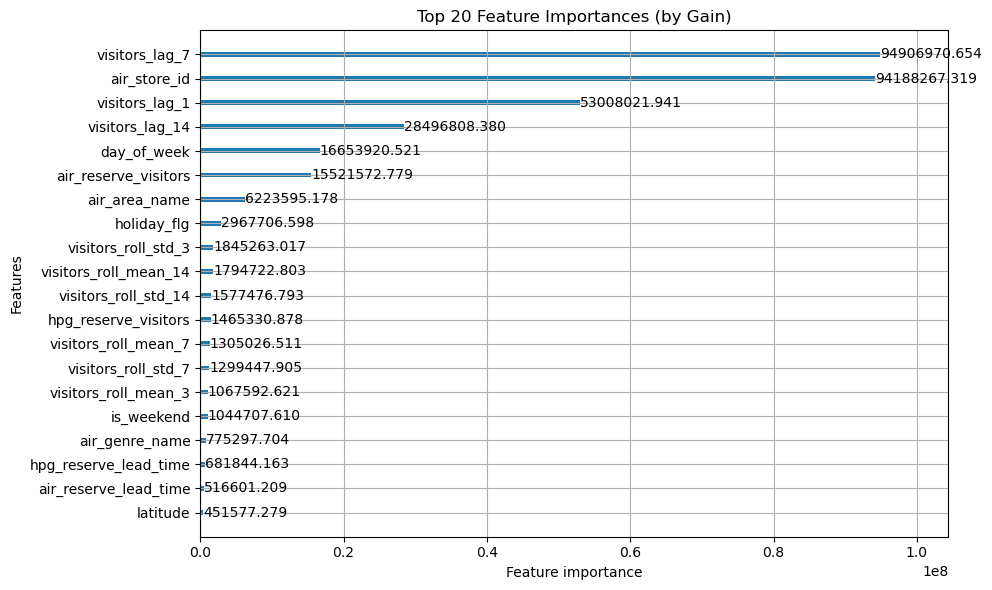

In [18]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

## 4. Integrating Prophet

In [19]:
from prophet import Prophet

In [20]:
# Count non-NaN visitors per store
store_counts = full_df.groupby('air_store_id')['visitors'].apply(lambda x: x.notna().sum()).sort_values(ascending=False)

# Pick a store with at least 50 non-NaN entries
valid_store_id = store_counts[store_counts >= 50].index[0]
print(f"Using store: {valid_store_id}")

Using store: 274


In [21]:
holidays = date_info[date_info['holiday_flg'] == 1][['visit_date']].rename(columns={
    'visit_date': 'ds'
})
holidays['holiday'] = 'japan_holiday'

In [22]:
store_df = full_df[(full_df['air_store_id'] == valid_store_id) & (full_df['visitors'].notnull())].copy()

prophet_df = store_df[['visit_date', 'visitors']].rename(columns={
    'visit_date': 'ds',
    'visitors': 'y'
})

In [23]:
print(prophet_df.head())
print(prophet_df['y'].notna().sum(), "non-NaN values in 'y'")

               ds   y
158602 2016-01-02  24
158603 2016-01-03  49
158604 2016-01-04  10
158605 2016-01-05   2
158606 2016-01-06   9
477 non-NaN values in 'y'


In [24]:
m = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m.fit(prophet_df)

13:28:41 - cmdstanpy - INFO - Chain [1] start processing
13:28:42 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Get number of future days to forecast (from your validation set)
forecast_horizon = valid_df[valid_df['air_store_id'] == valid_store_id]['visit_date'].nunique()

# Create future dataframe for Prophet
future = m.make_future_dataframe(periods=forecast_horizon)

# Generate forecast
forecast = m.predict(future)

In [26]:
# Merge Prophet forecast with actual validation data
store_forecast = forecast[['ds', 'yhat']].merge(
    valid_df[valid_df['air_store_id'] == valid_store_id][['visit_date', 'visitors']],
    left_on='ds',
    right_on='visit_date',
    how='inner'
)

In [27]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = store_forecast['visitors']
y_pred = np.clip(store_forecast['yhat'], 0, None)  # Remove negative predictions

prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Prophet RMSLE for {valid_store_id}: {prophet_rmsle:.4f}")

Prophet RMSLE for 274: 0.4460


## 5. Testing ARIMA

In [28]:
from statsmodels.tsa.arima.model import ARIMA

# Use the same store
arima_df = full_df[(full_df['air_store_id'] == valid_store_id)].copy()
arima_df = arima_df[['visit_date', 'visitors']].dropna()
arima_df = arima_df.set_index('visit_date').asfreq('D')  # Ensure daily frequency

In [29]:
arima_df['visitors'] = arima_df['visitors'].fillna(0)

In [30]:
arima_model = ARIMA(arima_df['visitors'], order=(5,1,0))
arima_model_fit = arima_model.fit()

In [31]:
n_days = valid_df[valid_df['air_store_id'] == valid_store_id]['visit_date'].nunique()
arima_forecast = arima_model_fit.forecast(steps=n_days)

In [32]:
actual = valid_df[valid_df['air_store_id'] == valid_store_id][['visit_date', 'visitors']].copy().reset_index(drop=True)
actual['arima_pred'] = np.clip(arima_forecast.values, 0, None)

In [33]:
from sklearn.metrics import mean_squared_log_error

arima_rmsle = np.sqrt(mean_squared_log_error(actual['visitors'], actual['arima_pred']))
print(f"ARIMA RMSLE for {valid_store_id}: {arima_rmsle:.4f}")

ARIMA RMSLE for 274: 0.6662


| Model    | RMSLE | Interpretation |
| -------- | ------- |  ------- |
| Prophet  | 0.4460    | Captures holiday + seasonal patterns effectively|
| RMSLE  | 0.6662  |  Struggles to generalize — likely overfits short-term noise  |

## 6. LightGBM + Prophet Ensemble

In [34]:
valid_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,...,is_weekend,visitors_lag_1,visitors_lag_7,visitors_lag_14,visitors_roll_mean_3,visitors_roll_std_3,visitors_roll_mean_7,visitors_roll_std_7,visitors_roll_mean_14,visitors_roll_std_14
87722,0,2017-03-01,17,3.0,11.0,4.0,11.0,6,44,35.694003,...,0,19.0,36.0,24.0,30.666667,6.658328,25.000000,8.755950,29.500000,8.899006
87723,0,2017-03-02,33,NaN,NaN,2.0,1.0,6,44,35.694003,...,0,17.0,33.0,41.0,34.666667,11.503623,29.857143,9.719886,29.928571,9.563265
87724,0,2017-03-03,29,NaN,NaN,NaN,NaN,6,44,35.694003,...,0,33.0,40.0,52.0,42.333333,6.350853,34.142857,9.191093,30.785714,10.452667
87725,0,2017-03-04,18,NaN,NaN,NaN,NaN,6,44,35.694003,...,1,29.0,28.0,35.0,34.000000,20.784610,31.285714,13.009154,29.642857,11.803566
87726,0,2017-03-06,18,NaN,NaN,NaN,NaN,6,44,35.694003,...,0,18.0,11.0,45.0,33.333333,20.231988,34.000000,13.453624,30.214286,12.317458


In [35]:
# Get LightGBM predictions for the store
store_valid = valid_df[valid_df['air_store_id'] == valid_store_id].copy()
store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

In [36]:
# Already renamed earlier
prophet_forecast = forecast[['ds', 'yhat']].rename(columns={
    'ds': 'visit_date',
    'yhat': 'prophet_pred'
})

In [37]:
ensemble_df = store_valid.merge(prophet_forecast, on='visit_date', how='inner')

In [38]:
alpha = 0.73  # LightGBM weight
ensemble_df['ensemble_pred'] = (
    alpha * ensemble_df['lgb_pred'] + (1 - alpha) * ensemble_df['prophet_pred']
)

In [39]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = ensemble_df['visitors']
y_pred = np.clip(ensemble_df['ensemble_pred'], 0, None)

ensemble_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Ensemble RMSLE for {valid_store_id}: {ensemble_rmsle:.4f}")

Ensemble RMSLE for 274: 0.4266


| RMSLE Score    | Interpretation                           |
| --------       | -------                                  |
| < 0.4          | Excellent — very tight predictions       |
| 0.4–0.6        | Solid performance                        |
| > 0.6          | Needs improvement or more feature tuning |


In [40]:
top_stores = (
    full_df.groupby('air_store_id')['visitors']
    .count()
    .sort_values(ascending=False)
    .head(10) #choosing 10 stores first for efficieny and validation
    .index.tolist()
)

In [41]:
results = []

for store_id in top_stores:
    # prepping data
    store_data = full_df[(full_df['air_store_id'] == store_id)].copy()
    prophet_df = store_data[['visit_date', 'visitors']].dropna().rename(columns={
        'visit_date': 'ds',
        'visitors': 'y'
    })
    
    if len(prophet_df) < 30:
        continue  # skip stores with too little history

    # fit prophet
    m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
    m.fit(prophet_df)

    # forecast into validation period
    forecast_horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
    future = m.make_future_dataframe(periods=forecast_horizon)
    forecast = m.predict(future)
    prophet_preds = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

    # get lgbm predictions
    store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
    store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

    # merge both predictions
    merged = store_valid.merge(prophet_preds, on='visit_date', how='inner')
    merged['ensemble_pred'] = 0.73 * merged['lgb_pred'] + 0.27 * merged['prophet_pred']  # use tuned alpha
    merged['ensemble_pred'] = np.clip(merged['ensemble_pred'], 0, None)

    # evaluate
    y_true = merged['visitors']
    y_pred = merged['ensemble_pred']
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))

    results.append({'store_id': store_id, 'rmsle': rmsle})

    print(f"Store: {store_id} → Ensemble RMSLE: {rmsle:.4f}")

13:28:42 - cmdstanpy - INFO - Chain [1] start processing
13:28:42 - cmdstanpy - INFO - Chain [1] done processing
13:28:42 - cmdstanpy - INFO - Chain [1] start processing
13:28:42 - cmdstanpy - INFO - Chain [1] done processing


Store: 274 → Ensemble RMSLE: 0.4266


13:28:42 - cmdstanpy - INFO - Chain [1] start processing
13:28:42 - cmdstanpy - INFO - Chain [1] done processing


Store: 161 → Ensemble RMSLE: 0.3121


13:28:43 - cmdstanpy - INFO - Chain [1] start processing


Store: 525 → Ensemble RMSLE: 0.4653


13:28:43 - cmdstanpy - INFO - Chain [1] done processing
13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:43 - cmdstanpy - INFO - Chain [1] done processing


Store: 705 → Ensemble RMSLE: 0.3891


13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:43 - cmdstanpy - INFO - Chain [1] done processing


Store: 290 → Ensemble RMSLE: 0.3952


13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:43 - cmdstanpy - INFO - Chain [1] done processing


Store: 361 → Ensemble RMSLE: 0.3962


13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:43 - cmdstanpy - INFO - Chain [1] done processing


Store: 93 → Ensemble RMSLE: 0.4945


13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:43 - cmdstanpy - INFO - Chain [1] done processing


Store: 385 → Ensemble RMSLE: 0.3688


13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:43 - cmdstanpy - INFO - Chain [1] done processing


Store: 429 → Ensemble RMSLE: 0.3893
Store: 665 → Ensemble RMSLE: 0.2901


In [42]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)

   store_id     rmsle
9       665  0.290113
1       161  0.312104
7       385  0.368832
3       705  0.389117
8       429  0.389330
4       290  0.395222
5       361  0.396208
0       274  0.426569
2       525  0.465322
6        93  0.494491


In [43]:
alpha = 0.73
results = []

for store_id in top_stores:
    try:
        store_data = full_df[full_df['air_store_id'] == store_id].copy()
        prophet_df = store_data[['visit_date', 'visitors']].dropna().rename(columns={
            'visit_date': 'ds', 'visitors': 'y'
        })

        if len(prophet_df) < 30:
            continue

        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)

        horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
        future = m.make_future_dataframe(periods=horizon)
        forecast = m.predict(future)
        prophet_pred_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

        store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
        store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

        merged = store_valid.merge(prophet_pred_df, on='visit_date', how='inner')
        merged['prophet_pred'] = np.clip(merged['prophet_pred'], 0, None)
        merged['lgb_pred'] = np.clip(merged['lgb_pred'], 0, None)

        y_true = merged['visitors']
        lgb_rmsle = np.sqrt(mean_squared_log_error(y_true, merged['lgb_pred']))
        prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, merged['prophet_pred']))

        # Conditional blending
        if prophet_rmsle < lgb_rmsle:
            merged['ensemble_pred'] = alpha * merged['lgb_pred'] + (1 - alpha) * merged['prophet_pred']
            method = "blend"
        else:
            merged['ensemble_pred'] = merged['lgb_pred']
            method = "lightgbm_only"

        final_rmsle = np.sqrt(mean_squared_log_error(y_true, merged['ensemble_pred']))

        results.append({
            'store_id': store_id,
            'rmsle': final_rmsle,
            'method': method,
            'lgb_rmsle': lgb_rmsle,
            'prophet_rmsle': prophet_rmsle
        })

        print(f"{store_id}: {method} → RMSLE: {final_rmsle:.4f}")

    except Exception as e:
        print(f"Store {store_id} failed: {e}")

13:28:43 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing
13:28:44 - cmdstanpy - INFO - Chain [1] start processing


274: lightgbm_only → RMSLE: 0.4299


13:28:44 - cmdstanpy - INFO - Chain [1] done processing
13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


161: blend → RMSLE: 0.3121


13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


525: lightgbm_only → RMSLE: 0.4648


13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


705: blend → RMSLE: 0.3891


13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


290: blend → RMSLE: 0.3952


13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


361: blend → RMSLE: 0.3962


13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


93: blend → RMSLE: 0.4945


13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing


385: blend → RMSLE: 0.3688


13:28:45 - cmdstanpy - INFO - Chain [1] start processing


429: blend → RMSLE: 0.3893


13:28:45 - cmdstanpy - INFO - Chain [1] done processing


665: lightgbm_only → RMSLE: 0.2934


In [44]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)
print(f"\nStores under 0.4 RMSLE: {(results_df['rmsle'] < 0.4).sum()} / {len(results_df)}")

   store_id     rmsle         method  lgb_rmsle  prophet_rmsle
9       665  0.293391  lightgbm_only   0.293391       0.312892
1       161  0.312104          blend   0.326292       0.286899
7       385  0.368832          blend   0.419185       0.413798
3       705  0.389117          blend   0.413692       0.367849
8       429  0.389330          blend   0.399779       0.368327
4       290  0.395222          blend   0.407801       0.367913
5       361  0.396208          blend   0.413303       0.395601
0       274  0.429913  lightgbm_only   0.429913       0.446040
2       525  0.464816  lightgbm_only   0.464816       0.509901
6        93  0.494491          blend   0.520658       0.440659

Stores under 0.4 RMSLE: 7 / 10


In [45]:
results = []

for store_id in top_stores:
    try:
        store_data = full_df[full_df['air_store_id'] == store_id].copy()
        prophet_df = store_data[['visit_date', 'visitors']].dropna().rename(columns={
            'visit_date': 'ds', 'visitors': 'y'
        })

        if len(prophet_df) < 30:
            continue

        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)
        horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
        future = m.make_future_dataframe(periods=horizon)
        forecast = m.predict(future)
        prophet_pred_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

        store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
        store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])
        merged = store_valid.merge(prophet_pred_df, on='visit_date', how='inner')

        y_true = merged['visitors']
        lgb_pred = np.clip(merged['lgb_pred'], 0, None)
        prophet_pred = np.clip(merged['prophet_pred'], 0, None)
        lgb_rmsle = np.sqrt(mean_squared_log_error(y_true, lgb_pred))

        best_rmsle = float('inf')
        best_alpha = None
        for alpha in np.linspace(0, 1, 21):  # from 0.0 to 1.0 in 0.05 steps
            blend = alpha * lgb_pred + (1 - alpha) * prophet_pred
            rmsle = np.sqrt(mean_squared_log_error(y_true, blend))
            if rmsle < best_rmsle:
                best_rmsle = rmsle
                best_alpha = alpha

        if best_rmsle < lgb_rmsle:
            if best_alpha == 0.0:
                method = "prophet_only"
            elif best_alpha == 1.0:
                method = "lightgbm_only"
            else:
                method = "blend"
            final_rmsle = best_rmsle
        else:
            method = "lightgbm_only"
            final_rmsle = lgb_rmsle
            best_alpha = 1.0

        results.append({
            'store_id': store_id,
            'rmsle': final_rmsle,
            'method': method,
            'best_alpha': best_alpha,
            'lgb_rmsle': lgb_rmsle,
            'prophet_rmsle': np.sqrt(mean_squared_log_error(y_true, prophet_pred))
        })

        print(f"{store_id}: {method.upper()} → RMSLE: {final_rmsle:.4f} (alpha={best_alpha:.2f})")

    except Exception as e:
        print(f"Store {store_id} failed: {e}")

13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing


274: BLEND → RMSLE: 0.4266 (alpha=0.75)


13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing
13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing


161: PROPHET_ONLY → RMSLE: 0.2869 (alpha=0.00)


13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing


525: BLEND → RMSLE: 0.4642 (alpha=0.90)


13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing


705: BLEND → RMSLE: 0.3638 (alpha=0.20)


13:28:46 - cmdstanpy - INFO - Chain [1] start processing
13:28:46 - cmdstanpy - INFO - Chain [1] done processing


290: PROPHET_ONLY → RMSLE: 0.3679 (alpha=0.00)


13:28:46 - cmdstanpy - INFO - Chain [1] start processing
13:28:46 - cmdstanpy - INFO - Chain [1] done processing


361: BLEND → RMSLE: 0.3885 (alpha=0.35)


13:28:46 - cmdstanpy - INFO - Chain [1] start processing
13:28:46 - cmdstanpy - INFO - Chain [1] done processing


93: PROPHET_ONLY → RMSLE: 0.4407 (alpha=0.00)


13:28:46 - cmdstanpy - INFO - Chain [1] start processing
13:28:46 - cmdstanpy - INFO - Chain [1] done processing


385: BLEND → RMSLE: 0.3394 (alpha=0.40)


13:28:46 - cmdstanpy - INFO - Chain [1] start processing
13:28:46 - cmdstanpy - INFO - Chain [1] done processing


429: PROPHET_ONLY → RMSLE: 0.3683 (alpha=0.00)
665: BLEND → RMSLE: 0.2901 (alpha=0.75)


In [46]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)
print(f"\nStores under 0.4 RMSLE: {(results_df['rmsle'] < 0.4).sum()} / {len(results_df)}")

   store_id     rmsle        method  best_alpha  lgb_rmsle  prophet_rmsle
1       161  0.286899  prophet_only        0.00   0.326292       0.286899
9       665  0.290099         blend        0.75   0.293391       0.312892
7       385  0.339427         blend        0.40   0.419185       0.413798
3       705  0.363798         blend        0.20   0.413692       0.367849
4       290  0.367913  prophet_only        0.00   0.407801       0.367913
8       429  0.368327  prophet_only        0.00   0.399779       0.368327
5       361  0.388534         blend        0.35   0.413303       0.395601
0       274  0.426571         blend        0.75   0.429913       0.446040
6        93  0.440659  prophet_only        0.00   0.520658       0.440659
2       525  0.464195         blend        0.90   0.464816       0.509901

Stores under 0.4 RMSLE: 7 / 10


## 7. Feature Engineering for LightGBM

In [47]:
full_df['visitors_lag_diff_7_1'] = full_df['visitors_lag_7'] - full_df['visitors_lag_1']
full_df['visitors_lag_diff_14_7'] = full_df['visitors_lag_14'] - full_df['visitors_lag_7']

In [48]:
def rolling_slope(series, window):
    return series.rolling(window).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True)

full_df['slope_roll_3'] = full_df.groupby('air_store_id')['visitors'].transform(lambda x: rolling_slope(x, 3))
full_df['slope_roll_7'] = full_df.groupby('air_store_id')['visitors'].transform(lambda x: rolling_slope(x, 7))

In [49]:
full_df['air_reserve_visitors'] = full_df['air_reserve_visitors'].fillna(0)
full_df['hpg_reserve_visitors'] = full_df['hpg_reserve_visitors'].fillna(0)

full_df['total_reserves'] = full_df['air_reserve_visitors'] + full_df['hpg_reserve_visitors']
full_df['reserve_lead_sum'] = full_df['air_reserve_lead_time'].fillna(0) + full_df['hpg_reserve_lead_time'].fillna(0)

In [50]:
train_means = full_df[full_df['visit_date'] < pd.to_datetime('2017-03-01')]

genre_means = train_means.groupby('air_genre_name')['visitors'].mean()
area_means = train_means.groupby('air_area_name')['visitors'].mean()

full_df['genre_mean_visitors'] = full_df['air_genre_name'].map(genre_means)
full_df['area_mean_visitors'] = full_df['air_area_name'].map(area_means)

In [51]:
full_df['holiday_weekend'] = ((full_df['holiday_flg'] == 1) & (full_df['is_weekend'] == 1)).astype(int)
full_df['holiday_dow'] = full_df['holiday_flg'] * full_df['day_of_week']

In [52]:
time_features = [
    'visitors_lag_1', 'visitors_lag_7', 'visitors_lag_14',
    'visitors_roll_mean_3', 'visitors_roll_std_3',
    'visitors_roll_mean_7', 'visitors_roll_std_7',
    'visitors_roll_mean_14', 'visitors_roll_std_14',
]

In [53]:
momentum_features = [
    'visitors_lag_diff_7_1', 'visitors_lag_diff_14_7',
    'slope_roll_3', 'slope_roll_7'
]

In [54]:
reservation_features = [
    'air_reserve_visitors', 'hpg_reserve_visitors',
    'air_reserve_lead_time', 'hpg_reserve_lead_time',
    'total_reserves', 'reserve_lead_sum'
]

In [55]:
encoded_metadata = [
    'genre_mean_visitors', 'area_mean_visitors'
]

In [56]:
calendar_features = [
    'day_of_week', 'holiday_flg', 'is_weekend',
    'holiday_weekend', 'holiday_dow'
]

In [57]:
location_features = [
    'latitude', 'longitude'
]

In [58]:
features = (
    time_features +
    momentum_features +
    reservation_features +
    encoded_metadata +
    calendar_features +
    location_features
)

In [59]:
categorical_features = ['day_of_week', 'holiday_flg', 'is_weekend']

In [60]:
for col in categorical_features:
    full_df[col] = full_df[col].astype('category')

In [61]:
full_df['visit_date'] = pd.to_datetime(full_df['visit_date'])
cutoff_date = pd.to_datetime('2017-03-01')

train_df = full_df[full_df['visit_date'] < cutoff_date]
valid_df = full_df[full_df['visit_date'] >= cutoff_date]

In [62]:
train_set = lgb.Dataset(train_df[features], label=train_df['visitors'], categorical_feature=categorical_features)
valid_set = lgb.Dataset(valid_df[features], label=valid_df['visitors'], categorical_feature=categorical_features)

In [63]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'seed': 42
}

lgb_model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7.44034	valid_1's rmse: 9.04532
[200]	training's rmse: 7.1565	valid_1's rmse: 8.85163
[300]	training's rmse: 7.02458	valid_1's rmse: 8.79886
[400]	training's rmse: 6.90646	valid_1's rmse: 8.77039
[500]	training's rmse: 6.80488	valid_1's rmse: 8.73615
[600]	training's rmse: 6.71449	valid_1's rmse: 8.70987
[700]	training's rmse: 6.64191	valid_1's rmse: 8.69416
[800]	training's rmse: 6.56392	valid_1's rmse: 8.68566
[900]	training's rmse: 6.49624	valid_1's rmse: 8.67778
[1000]	training's rmse: 6.42588	valid_1's rmse: 8.66576
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 6.42688	valid_1's rmse: 8.6652


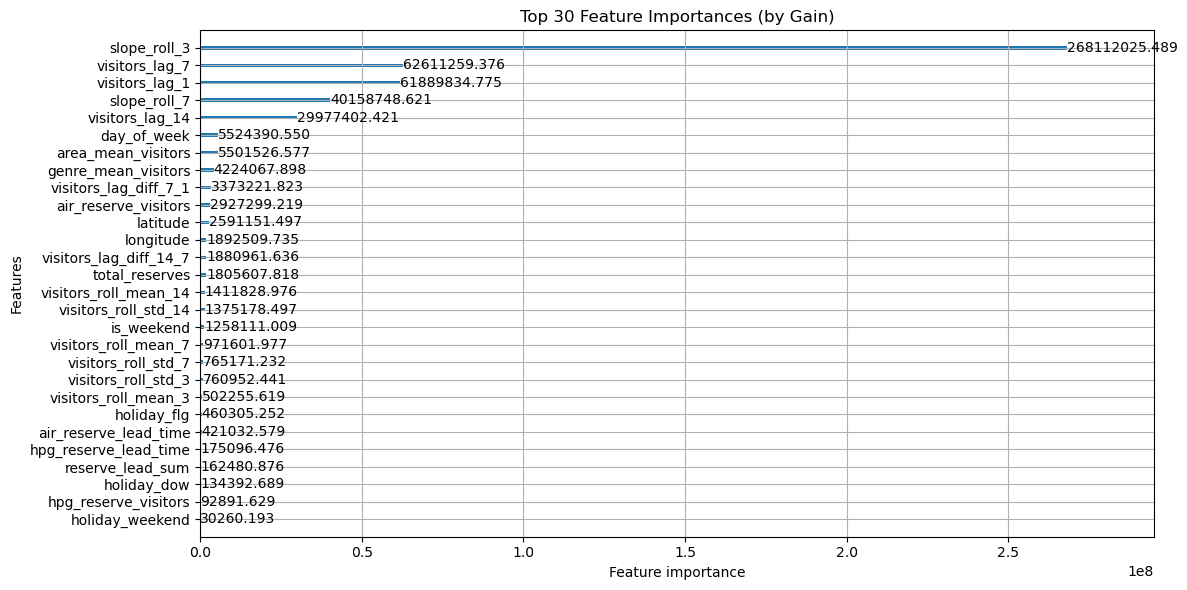

In [64]:
lgb.plot_importance(
    lgb_model,
    max_num_features=30,
    importance_type='gain',
    figsize=(12, 6)
)
plt.title("Top 30 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

In [65]:
results = []

for store_id in top_stores:
    try:
        store_prophet_df = full_df[full_df['air_store_id'] == store_id][['visit_date', 'visitors']].dropna()
        prophet_df = store_prophet_df.rename(columns={'visit_date': 'ds', 'visitors': 'y'})

        if len(prophet_df) < 30:
            continue

        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)
        horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
        future = m.make_future_dataframe(periods=horizon)
        forecast = m.predict(future)
        prophet_preds = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

        store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
        store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])
        merged = store_valid.merge(prophet_preds, on='visit_date', how='inner')

        y_true = merged['visitors']
        lgb_pred = np.clip(merged['lgb_pred'], 0, None)
        prophet_pred = np.clip(merged['prophet_pred'], 0, None)

        lgb_rmsle = np.sqrt(mean_squared_log_error(y_true, lgb_pred))
        prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, prophet_pred))

        best_rmsle = float('inf')
        best_alpha = None
        for alpha in np.linspace(0, 1, 21):  # 0.00 to 1.00
            blend = alpha * lgb_pred + (1 - alpha) * prophet_pred
            rmsle = np.sqrt(mean_squared_log_error(y_true, blend))
            if rmsle < best_rmsle:
                best_rmsle = rmsle
                best_alpha = alpha

        if best_rmsle < lgb_rmsle:
            if best_alpha == 0.0:
                method = "prophet_only"
            elif best_alpha == 1.0:
                method = "lightgbm_only"
            else:
                method = "blend"
            final_rmsle = best_rmsle
        else:
            method = "lightgbm_only"
            final_rmsle = lgb_rmsle
            best_alpha = 1.0

        results.append({
            'store_id': store_id,
            'rmsle': final_rmsle,
            'method': method,
            'best_alpha': best_alpha,
            'lgb_rmsle': lgb_rmsle,
            'prophet_rmsle': prophet_rmsle
        })

        print(f"{store_id}: {method.upper()} → RMSLE: {final_rmsle:.4f} (α={best_alpha:.2f})")

    except Exception as e:
        print(f"Store {store_id} failed: {e}")

13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:01 - cmdstanpy - INFO - Chain [1] done processing
13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:01 - cmdstanpy - INFO - Chain [1] done processing
13:29:01 - cmdstanpy - INFO - Chain [1] start processing


274: BLEND → RMSLE: 0.3503 (α=0.65)
161: BLEND → RMSLE: 0.1956 (α=0.75)


13:29:01 - cmdstanpy - INFO - Chain [1] done processing
13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:01 - cmdstanpy - INFO - Chain [1] done processing
13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:01 - cmdstanpy - INFO - Chain [1] done processing


525: LIGHTGBM_ONLY → RMSLE: 0.3481 (α=1.00)
705: BLEND → RMSLE: 0.2954 (α=0.60)


13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:01 - cmdstanpy - INFO - Chain [1] done processing
13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:01 - cmdstanpy - INFO - Chain [1] done processing


290: BLEND → RMSLE: 0.2724 (α=0.90)
361: BLEND → RMSLE: 0.3191 (α=0.75)


13:29:02 - cmdstanpy - INFO - Chain [1] start processing
13:29:02 - cmdstanpy - INFO - Chain [1] done processing
13:29:02 - cmdstanpy - INFO - Chain [1] start processing


93: BLEND → RMSLE: 0.3277 (α=0.90)
385: BLEND → RMSLE: 0.2601 (α=0.70)


13:29:02 - cmdstanpy - INFO - Chain [1] done processing
13:29:02 - cmdstanpy - INFO - Chain [1] start processing
13:29:02 - cmdstanpy - INFO - Chain [1] done processing


429: BLEND → RMSLE: 0.2901 (α=0.70)
665: BLEND → RMSLE: 0.2180 (α=0.65)


In [66]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)
print(f"\nStores under 0.4 RMSLE: {(results_df['rmsle'] < 0.4).sum()} / {len(results_df)}")

   store_id     rmsle         method  best_alpha  lgb_rmsle  prophet_rmsle
1       161  0.195647          blend        0.75   0.214408       0.286899
9       665  0.217990          blend        0.65   0.272584       0.312892
7       385  0.260138          blend        0.70   0.279382       0.413798
4       290  0.272408          blend        0.90   0.274634       0.367913
8       429  0.290124          blend        0.70   0.313712       0.368327
3       705  0.295356          blend        0.60   0.321963       0.367849
5       361  0.319109          blend        0.75   0.334662       0.395601
6        93  0.327715          blend        0.90   0.329551       0.440659
2       525  0.348084  lightgbm_only        1.00   0.348084       0.509901
0       274  0.350288          blend        0.65   0.421372       0.446040

Stores under 0.4 RMSLE: 10 / 10


## 8. Finding the Best Global Alpha (Across All Stores)

In [71]:
all_validation_preds = []

for store_id in full_df['air_store_id'].unique():
    try:
        store_data = full_df[full_df['air_store_id'] == store_id].copy()
        store_data['visit_date'] = pd.to_datetime(store_data['visit_date'])
        val_cutoff = pd.to_datetime('2017-03-01')

        train_df = store_data[store_data['visit_date'] < val_cutoff]
        val_df = store_data[store_data['visit_date'] >= val_cutoff]

        if len(train_df) < 30 or val_df.empty:
            continue

        prophet_df = train_df[['visit_date', 'visitors']].rename(columns={'visit_date': 'ds', 'visitors': 'y'})
        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)

        future = val_df[['visit_date']].rename(columns={'visit_date': 'ds'})
        forecast = m.predict(future)
        val_df = val_df.merge(forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'}),
                              on='visit_date', how='left')

        val_df['lgb_pred'] = lgb_model.predict(val_df[features])

        all_validation_preds.append(val_df[['air_store_id', 'visit_date', 'visitors', 'lgb_pred', 'prophet_pred']])

    except Exception as e:
        print(f"Store {store_id} skipped: {e}")

13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1]

In [72]:
all_validation_preds = pd.concat(all_validation_preds, axis=0)

In [73]:
alphas = np.linspace(0, 1, 21)  # 0.00 to 1.00 in steps of 0.05
results = []

for alpha in alphas:
    blended = (
        alpha * all_validation_preds['lgb_pred'] +
        (1 - alpha) * all_validation_preds['prophet_pred']
    )

    y_true = all_validation_preds['visitors']
    y_pred = np.clip(blended, 0, None)

    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    results.append({'alpha': alpha, 'rmsle': rmsle})

# Convert to DataFrame
alpha_df = pd.DataFrame(results).sort_values('rmsle')
print(alpha_df)

best_alpha = alpha_df.iloc[0]['alpha']
print(f"\nBest global alpha = {best_alpha:.2f} with RMSLE = {alpha_df.iloc[0]['rmsle']:.4f}")

    alpha     rmsle
20   1.00  0.409215
19   0.95  0.428990
18   0.90  0.456803
17   0.85  0.476209
16   0.80  0.491962
15   0.75  0.507369
14   0.70  0.523698
13   0.65  0.540864
12   0.60  0.560823
11   0.55  0.582748
10   0.50  0.606850
9    0.45  0.631843
8    0.40  0.658580
7    0.35  0.686589
6    0.30  0.715744
5    0.25  0.745516
4    0.20  0.777180
3    0.15  0.810343
2    0.10  0.845510
1    0.05  0.881530
0    0.00  0.918452

Best global alpha = 1.00 with RMSLE = 0.4092


## 8. Test Set!

In [90]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

air_visit = pd.read_csv('data/air_visit_data.csv')
air_reserve = pd.read_csv('data/air_reserve.csv')
hpg_reserve = pd.read_csv('data/hpg_reserve.csv')
air_store_info = pd.read_csv('data/air_store_info.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')
store_id_relation = pd.read_csv('data/store_id_relation.csv')
date_info = pd.read_csv('data/date_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date'])
air_visit = air_visit.groupby(['air_store_id', 'visit_date'])['visitors'].sum().reset_index()

date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
date_info['day_of_week'] = pd.Categorical(date_info['day_of_week'], 
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ordered=True).codes
date_info['is_weekend'] = date_info['day_of_week'].isin([5, 6]).astype(int)


full_df = air_visit.merge(date_info, on='visit_date', how='left')

full_df = full_df.merge(air_store_info, on='air_store_id', how='left')

for col in ['air_genre_name', 'air_area_name']:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col])

full_df = full_df.sort_values(['air_store_id', 'visit_date'])
for lag in [1, 7, 14]:
    full_df[f'visitors_lag_{lag}'] = full_df.groupby('air_store_id')['visitors'].shift(lag)

for win in [3, 7, 14]:
    full_df[f'visitors_roll_mean_{win}'] = full_df.groupby('air_store_id')['visitors'].transform(lambda x: x.shift(1).rolling(win).mean())

holiday_agg = full_df.groupby('air_store_id')['holiday_flg'].mean().reset_index().rename(columns={'holiday_flg': 'holiday_mean'})
full_df = full_df.merge(holiday_agg, on='air_store_id', how='left')

features = [
    'day_of_week', 'holiday_flg', 'is_weekend', 'holiday_mean',
    'air_genre_name', 'air_area_name', 'latitude', 'longitude'
] + [
    f'visitors_lag_{lag}' for lag in [1, 7, 14]
] + [
    f'visitors_roll_mean_{win}' for win in [3, 7, 14]
]

full_df = full_df.dropna()
X = full_df[features]
y = full_df['visitors']

train_set = lgb.Dataset(X, label=y)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'seed': 42
}

lgb_model = lgb.train(params, train_set, num_boost_round=1000)

sample_submission['air_store_id'] = sample_submission['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = pd.to_datetime(sample_submission['id'].apply(lambda x: x.split('_')[-1]))

test_keys = sample_submission[['id', 'air_store_id', 'visit_date']].copy()

test_df = test_keys.merge(date_info, on='visit_date', how='left')
test_df = test_df.merge(air_store_info, on='air_store_id', how='left')

for col in ['air_genre_name', 'air_area_name']:
    test_df[col] = le.fit_transform(test_df[col])

lag_roll_features = [col for col in features if col not in test_df.columns]
test_df = test_df.merge(full_df[['air_store_id', 'visit_date'] + lag_roll_features], on=['air_store_id', 'visit_date'], how='left')

for col in features:
    if col not in test_df.columns:
        test_df[col] = 0

X_test = test_df[features]
test_df['visitors'] = lgb_model.predict(X_test)
test_df['visitors'] = np.clip(test_df['visitors'], 0, None)

submission = test_keys[['id']].copy()
submission = submission.merge(test_df[['id', 'visitors']], on='id', how='left')
submission['visitors'] = submission['visitors'].fillna(0)

submission.to_csv('predictions/prediction.csv', index=False)
print("Submission file saved")

Submission file saved
